In [2]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject, CUDA, DifferentialEquations, PyPlot, NNlib,  ImageFiltering, Images, MEngProject.LaminartKernels, MEngProject.LaminartInitFunc, MEngProject.Utils, BenchmarkTools, Test

using OrdinaryDiffEq, ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise

batch = 1


files = readdir(datadir("img"))

┌ Info: Precompiling MEngProject [d0493a11-efc0-4c7c-9b66-d0bd5a04cc55]
└ @ Base loading.jl:1260


25-element Array{String,1}:
 ".ipynb_checkpoints"
 "Iine_gap_1_100_gs.png"
 "Iine_gap_2_100_gs.png"
 "Iine_gap_3_100_gs.png"
 "Iine_gap_4_100_gs.png"
 "Iines_gaps_100_gs.png"
 "diag_dots_100_gs.png"
 "diag_gap_100_gs.png"
 "kan_sq_cont.png"
 "kan_sq_cont_l.png"
 "mo05709.png"
 "stairs_100gs.png"
 "stairs_200gs.png"
 "viper00187.png"
 "viper00661.jpg"
 "viper00715.png"
 "viper00717.png"
 "viper00720.png"
 "viper00721.png"
 "viper00842.jpg"
 "viper00891.jpg"
 "viper00904.jpg"
 "viper00921.jpg"
 "viper01006.jpg"
 "viper01333.jpg"

┌ Info: Precompiling MEngProject [d0493a11-efc0-4c7c-9b66-d0bd5a04cc55]
└ @ Base loading.jl:1260
┌ Info: Precompiling ImageIO [82e4d734-157c-48bb-816b-45c225c6df19]
└ @ Base loading.jl:1260


UndefVarError: UndefVarError: prob not defined

In [ ]:
y1Res_cpu

In [3]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject,
    CUDA,
    DifferentialEquations,
    PyPlot,
    NNlib,
    ImageFiltering,
    Images,
    MEngProject.LaminartKernels,
    MEngProject.LaminartInitFunc,
    MEngProject.Utils,
    BenchmarkTools,
    Test

using OrdinaryDiffEq,
    ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise

batch = 1


files = readdir(datadir("res_test"))[2:end]

global benchm_gpu = []
global benchm_cpu = []
global y1Res_gpu = []
global y1Res_cpu = []

# @inbounds begin
    tspan = (0.0f0, 10f0)

    batch_ = string(batch, "_", rand(1000:9999))
    mkdir(plotsdir(string("bench_dim", batch_)))


    test_name = ["025", "050", "075", "100", "200", "300", "400"]
    test_name_plt = [
        "\$25×25\$",
        "\$50×50\$",
        "\$75×75\$",
        "\$100×100\$",
        "\$200×200\$",
        "\$300×300\$",
        "\$400×400\$",
    ]


    for file in enumerate(files[1:1])

        p = LaminartInitFunc.parameterInit_conv_gpu(
            datadir("res_test", file[2]),
            Parameters.parameters_f32,
        )

        u0 = cu(reshape(
            zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
            p.dim_i,
            p.dim_j,
            5 * p.K + 2,
            1,
        ))

        arr1 = similar(u0[:, :, 1:2, :])
        arr2 = similar(u0[:, :, 1:1, :])

        f = LaminartFunc.LamFunction(
            arr1, #x
            similar(arr1), #m
            similar(arr1), #s
            arr2, #x_lgn,
            similar(arr1), #C,
            similar(arr1), #H_z,
            similar(arr1), # dy_temp,
            similar(arr1), # dm_temp,
            similar(arr1), # dz_temp,
            similar(arr1), # ds_temp,
            similar(arr2), # dv_temp,
            similar(arr1), # H_z_temp,
            similar(arr2), #  V_temp_1,
            similar(arr2), #  V_temp_2,
            similar(arr1), #  A_temp,
            similar(arr1), #   B_temp
        )

        prob = ODEProblem(f, u0, tspan, p)
        push!(benchm_gpu, @benchmark solve(prob))
        sol = solve(prob)


        t = 10
        v0 = @view sol(t)[:, :, :, 1]
        axMax = findmax(v0)[1]


        k = 7
		k2 = 8
        fig, ax = plt.subplots()

        v1 = @view sol(t)[:, :, k, 1]
        v2 = @view sol(t)[:, :, k+1, 1]
        im = ax.imshow(
            v1,
            cmap = matplotlib.cm.PRGn,
            vmax = axMax,
            vmin = -axMax,
        )
        im2 = ax.imshow(
            v2,
            cmap = matplotlib.cm.RdBu_r,
            vmax = axMax,
            vmin = -axMax,
            alpha = 0.5,
        )

        cbar = fig.colorbar(im2, shrink = 0.9, ax = ax)
        cbar.ax.set_xlabel("\$k=$k2\$")
        cbar = fig.colorbar(im, shrink = 0.9, ax = ax)
        cbar.ax.set_xlabel("\$k=$k\$")
        layer = Utils.layers[k]
        plt.title(string(
            "Layer: $layer, \$t=$t\$, resolution=",
            test_name_plt[file[1]],
        ))
        plt.axis("off")
        fig.tight_layout()
        plt.savefig(plotsdir(
            string("bench_dim", batch_),
            string(
                file[2],
                "_res_",
                test_name[file[1]],
                "_t",
                t,
                "_",
                Utils.la[k],
                ".png",
            ),
        ))
        close("all")

		v3 = @view sol[:,:,7:7,:,:]
		push!(y1Res, Array(v3))
		u0 = nothing
		p = nothing
		arr1 = nothing
		arr2 = nothing
		f = nothing
		prob = nothing
		sol = nothing


		p = LaminartInitFunc.parameterInit_conv_cpu(
            datadir("res_test", file[2]),
            Parameters.parameters_f32,
        )

        u0 = reshape(
            zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
            p.dim_i,
            p.dim_j,
            5 * p.K + 2,
            1,
        )

        arr1 = similar(u0[:, :, 1:2, :])
        arr2 = similar(u0[:, :, 1:1, :])

        f = LaminartFunc.LamFunction(
            arr1, #x
            similar(arr1), #m
            similar(arr1), #s
            arr2, #x_lgn,
            similar(arr1), #C,
            similar(arr1), #H_z,
            similar(arr1), # dy_temp,
            similar(arr1), # dm_temp,
            similar(arr1), # dz_temp,
            similar(arr1), # ds_temp,
            similar(arr2), # dv_temp,
            similar(arr1), # H_z_temp,
            similar(arr2), #  V_temp_1,
            similar(arr2), #  V_temp_2,
            similar(arr1), #  A_temp,
            similar(arr1), #   B_temp
        )

        prob = ODEProblem(f, u0, tspan, p)
        push!(benchm_cpu, @benchmark solve(prob))
        sol = solve(prob)

		push!(y1Res_cpu, sol[:,:,7:7,:,:])
		u0 = nothing
		p = nothing
		arr1 = nothing
		arr2 = nothing
		f = nothing
		prob = nothing
		sol = nothing
	end

    # time plot
    fig, axs = plt.subplots()

    for result ∈ enumerate(y1Res_gpu)
		lab = "$test_name[result[1]]"
        axs.plot(result[2][findmax(result[2][:, :, 1, 1, end])[2][1], findmax(result[2][:, :, 1, 1, end])[2][2], k, 1, :], c = Utils.Colour[result[1]], "--", label = "$lab GPU")
    end

	for result ∈ enumerate(y1Res_cpu)
		lab = "$test_name[result[1]]"
		axs.plot(result[2][findmax(result[2][:, :, 1, 1, end])[2][1], findmax(result[2][:, :, 1, 1, end])[2][2], k, 1, :], c = Utils.Colour[result[1]],":", label = "$lab CPU")
	end
    axs.set_xlabel("Time")
    axs.set_ylabel("Activation")
    plt.title("L2/3, \$k=1\$")
    plt.legend()
    fig.tight_layout()
    plt.savefig(plotsdir(
        string("bench_dim", batch_),
        string(file[2], "_para_", test_name[file[1]], "_time.png"),
    ))
    close("all")



    # benchmark plot

    fig, ax = plt.subplots()
    for bm ∈ enumerate(benchm_gpu)
        ax.scatter(
		median(bm[2].times) * 1e-9,
		test_name_plt[bm[1]],
            label = "GPU",
			color=Utils.colours[1],
            alpha = 0.3,
            edgecolors = "none",
        )
    end

	for bm ∈ enumerate(benchm_cpu)
		ax.scatter(
            median(bm[2].times) * 1e-9,
			test_name_plt[bm[1]],
			label = "CPU",
			alpha = 0.3,
			color=Utils.colours[2],
			edgecolors = "none",
		)
	end

    ax.legend()
	axs.set_xlabel("Resolution (\$px\$)")
    axs.set_ylabel("Time (\$s\$)")
    ax.grid(True)
    fig.tight_layout()
    plt.savefig(plotsdir(
        string("bench_dim", batch_),
        string(file[2], "_para_", test_name[file[1]], "_time.png"),
    ))
    close("all")

	# memory
	fig, ax = plt.subplots()
    for bm ∈ enumerate(benchm_gpu)
        ax.scatter(
            bm[2].memory * 1e-6,
            test_name_plt[bm[1]],
			olor=Utils.colours[1],
            label = "GPU",
            alpha = 0.3,
            edgecolors = "none",
        )
    end

    ax.legend()
	axs.set_xlabel("Resolution (\$px\$)")
    axs.set_ylabel("Memory")
    ax.grid(True)
    fig.tight_layout()
    plt.savefig(plotsdir(
        string("bench_dim", batch_),
        string(file[2], "_para_", test_name[file[1]], "_time.png"),
    ))
    close("all")
end
# end



UndefVarError: UndefVarError: prob not defined

In [4]:
readdir(datadir("res_test"))

8-element Array{String,1}:
 ".ipynb_checkpoints"
 "ver_lines_025_gs.png"
 "ver_lines_050_gs.png"
 "ver_lines_075_gs.png"
 "ver_lines_100_gs.png"
 "ver_lines_200_gs.png"
 "ver_lines_300_gs.png"
 "ver_lines_400_gs.png"

In [ ]:
using DrWatson
@quickactivate "MEngProject"
using MEngProject,
    CUDA,
    DifferentialEquations,
    PyPlot,
    NNlib,
    ImageFiltering,
    Images,
    MEngProject.LaminartKernels,
    MEngProject.LaminartInitFunc,
    MEngProject.Utils,
    BenchmarkTools,
    Test

using OrdinaryDiffEq,
    ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise

batch = 1


# files = readdir(datadir("img"))
files = ["kan_sq_cont_l.png", "stairs_200gs.png"]

tspan = (0.0f0, 800f0)

batch_ = string(batch, "_", rand(1000:9999))
mkdir(plotsdir(string("noise", batch_)))
# for file in files[1:end]
    for noise in [0.2f0, 0.4f0, 0.7f0, 1f0, 1.5f0, 2f0]
        try
            p = LaminartInitFunc.parameterInit_conv_gpu_noise(
                datadir("img", file),
                Parameters.parameters_f32,
                noise,
            )

            u0 = cu(reshape(
                zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
                p.dim_i,
                p.dim_j,
                5 * p.K + 2,
                1,
            ))

            arr1 = similar(u0[:, :, 1:2, :])
            arr2 = similar(u0[:, :, 1:1, :])

            f = LaminartFunc.LamFunction(
                arr1, #x
                similar(arr1), #m
                similar(arr1), #s
                arr2, #x_lgn,
                similar(arr1), #C,
                similar(arr1), #H_z,
                similar(arr1), # dy_temp,
                similar(arr1), # dm_temp,
                similar(arr1), # dz_temp,
                similar(arr1), # ds_temp,
                similar(arr2), # dv_temp,
                similar(arr1), # H_z_temp,
                similar(arr2), #  V_temp_1,
                similar(arr2), #  V_temp_2,
                similar(arr1), #  A_temp,
                similar(arr1), #   B_temp
            )

            prob = ODEProblem(f, u0, tspan, p)
            # 	@benchmark sol = solve(prob)
            sol = solve(prob)


            for t ∈ [25, 50, 100, 200, 400, 800]
                # 				for t ∈ [25,50,100]
                @inbounds begin
                    v0 = @view sol(t)[:, :, :, 1]
                    axMax = findmax(v0)[1]

                    for k ∈ 1:2:10
                        k2 = k + 1
                        fig, ax = plt.subplots()

                        v1 = @view sol(t)[:, :, k, 1]
                        v2 = @view sol(t)[:, :, k+1, 1]
                        im = ax.imshow(
                            v1,
                            cmap = matplotlib.cm.PRGn,
                            vmax = axMax,
                            vmin = -axMax,
                        )
                        im2 = ax.imshow(
                            v2,
                            cmap = matplotlib.cm.RdBu_r,
                            vmax = axMax,
                            vmin = -axMax,
                            alpha = 0.5,
                        )

                        cbar = fig.colorbar(im2, shrink = 0.9, ax = ax)
                        cbar.ax.set_xlabel("\$k=$k2\$")
                        cbar = fig.colorbar(im, shrink = 0.9, ax = ax)
                        cbar.ax.set_xlabel("\$k=$k\$")
                        layer = Utils.layers[k]
                        plt.title("Layer: $layer, \$t=$t\$, noise\$σ=$noise\$")
                        plt.axis("off")
                        fig.tight_layout()
                        plt.savefig(plotsdir(
                            string("noise", batch_),
                            string(
                                file,
                                "_noise_",
                                noise,
                                "_t",
                                t,
                                "_",
                                Utils.la[k],
                                ".png",
                            ),
                        ))
                        close("all")
                    end


                    k = 11
                    fig, ax = plt.subplots()
                    v1 = @view sol[:, :, k, 1, t]
                    v2 = @view sol[:, :, k+1, 1, t]
                    im = ax.imshow(
                        v1,
                        cmap = matplotlib.cm.PRGn,
                        vmax = axMax,
                        vmin = -axMax,
                    )
                    im2 = ax.imshow(
                        v2,
                        cmap = matplotlib.cm.RdBu_r,
                        vmax = axMax,
                        vmin = -axMax,
                        alpha = 0.5,
                    )

                    cbar = fig.colorbar(im2, shrink = 0.9, ax = ax)
                    cbar.ax.set_xlabel("\$v^-\$")
                    cbar = fig.colorbar(im, shrink = 0.9, ax = ax)
                    cbar.ax.set_xlabel("\$v^+\$")

                    layer = Utils.layers[k]
                    plt.title("Layer: $layer, \$t=$t\$, noise\$σ=$noise\$")
                    plt.axis("off")
                    fig.tight_layout()

                    plt.savefig(plotsdir(
                        string("noise", batch_),
                        string(
                            file,
                            "_noise_",
                            noise,
                            "_t",
                            t,
                            "_",
                            Utils.la[k],
                            ".png",
                        ),
                    ))
                    close("all")
                end
            end
        finally
            nothing
        end


        # time plot
        fig, axs = plt.subplots()

        for k ∈ 1:12
            v3 = @view sol[:, :, k, 1, end]
            v4 = @view sol[findmax(v3)[2][1], findmax(v3)[2][2], k, 1, :]
            layer = Utils.layers_1[k]
            axs.plot(v4, Utils.lines[k], label = "$layer")
        end
        axs.set_xlabel("Time")
        axs.set_ylabel("Activation")
        plt.title("Noise \$σ=$noise\$")
        plt.legend()
        fig.tight_layout()
        plt.savefig(plotsdir(
            string("noise", batch_),
            string(file, "_noise_", noise, "_time.png"),
        ))
        u0 = nothing
        p = nothing
        arr1 = nothing
        arr2 = nothing
        f = nothing
        prob = nothing
        sol = nothing
        close("all")
    end
end


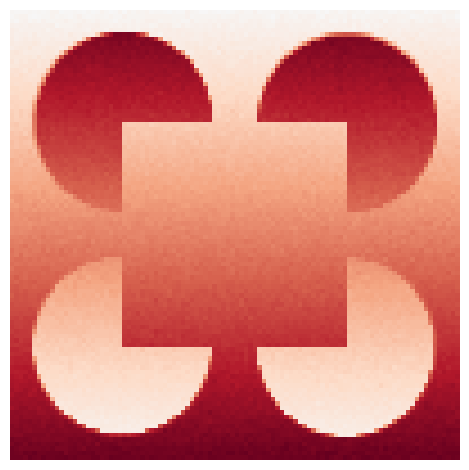

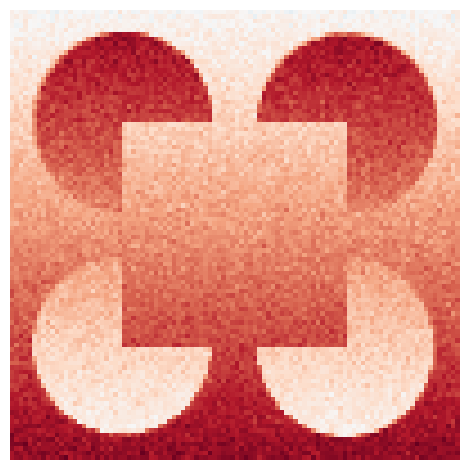

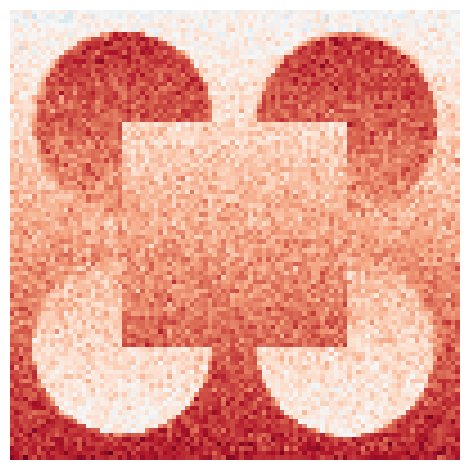

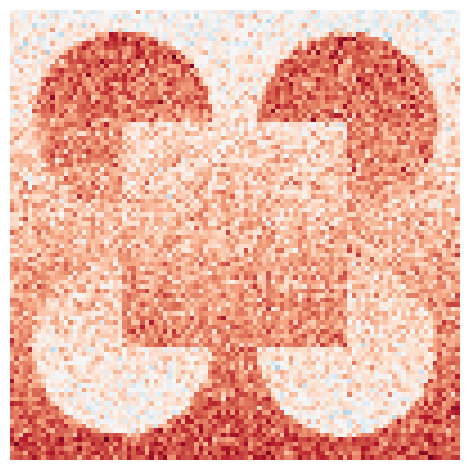

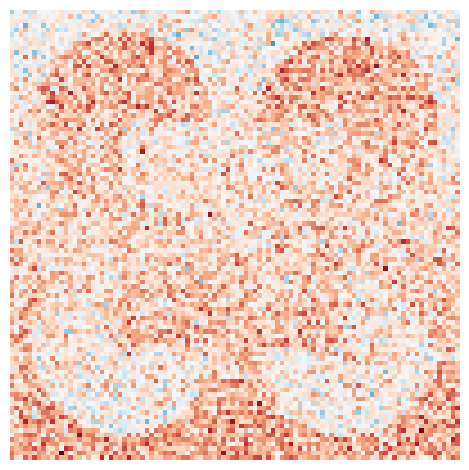

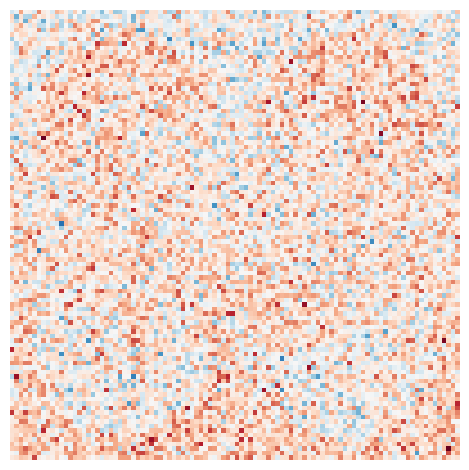

┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /mnt/storage_1/users/cullinanen/.julia/dev/MEngProject.jl/src/LaminartInitFunc.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /mnt/storage_1/users/cullinanen/.julia/packages/Revise/BqeJF/src/Revise.jl:820
┌ Warning: Due to a previously reported error, the running code does not match saved version for the following files:
│ 
│   /mnt/storage_1/users/cullinanen/.julia/dev/MEngProject.jl/src/LaminartInitFunc.jl
│ 
│ Use Revise.errors() to report errors again.
└ @ Revise /mnt/storage_1/users/cullinanen/.julia/packages/Revise/BqeJF/src/Revise.jl:820


In [27]:
files = ["kan_sq_cont_l.png", "stairs_200gs.png"]

# tspan = (0.0f0, 800f0)

# batch_ = string(batch, "_", rand(1000:9999))
# mkdir(plotsdir(string("noise", batch_)))
# for file in files[1:end]
for noise ∈ [0.01f0, 0.05f0, 0.1f0, 0.2f0, 0.5f0, 1f0]

            p = LaminartInitFunc.parameterInit_conv_gpu_noise(
                datadir("img", files[1]),
                Parameters.parameters_f32,
                noise,
            );
Utils.plot_rb(p.I[:,:,1,1],axMax=findmax(p.I)[1], axMin=-findmax(p.I)[1])
end

In [23]:
axMax=findmin(p.I)[1]

0.011764706f0

In [15]:
findmax(p.I)[1]

1.5959865f0

In [35]:
p = LaminartInitFunc.parameterInit_conv_gpu_noise(
                datadir("img",files[1]),
                Parameters.parameters_f32,
                noise,
            )

(K = 2, δ_v = 1.25f0, δ_c = 0.25f0, δ_m = 0.01875f0, δ_z = 0.125f0, δ_s = 2.5f0, σ_1 = 1.0f0, C_1 = 1.5f0, C_2 = 0.075f0, σ_2 = 0.5f0, γ = 10.0f0, α = 0.5f0, ϕ = 2.0f0, Γ = 0.2f0, v_21 = 0.0f0, μ = 2.0f0, ν = 1.1f0, n = 6.0f0, att = 0.0f0, η_p = 2.1f0, η_m = 1.5f0, λ = 1.5f0, a_23_ex = 3.0f0, a_23_in = 0.5f0, v12_6 = 1.0f0, v12_4 = 5.0f0, ψ = 0.5f0, C_AB_l = 5, H_σ_x = 3.0f0, H_σ_y = 0.8f0, H_fact = 13.0f0, H_l = 19, T_fact = Float32[0.87, 0.13], T_p_m = 0.302f0, T_v2_fact = 0.625f0, H_size = 19, W_size = 19, W_p_σ_x_same_a = 6.0f0, W_p_σ_x_same_b = 3.0f0, W_p_σ_y_same_a = 2.0f0, W_p_σ_y_same_b = 4.0f0, W_p_σ_opp_a = 4.0f0, W_p_σ_x_opp_b = 3.0f0, W_p_σ_x_opp_c = 1.2f0, W_p_σ_y_opp_b = 1.2f0, W_p_σ_y_opp_c = 3.0f0, W_p_same_fact = 39.0f0, W_p_opp_fact_a = 70.0f0, W_p_opp_fact_b = 50.0f0, W_m_σ_x_same_a = 6.0f0, W_m_σ_x_same_b = 3.0f0, W_m_σ_y_same_a = 2.5f0, W_m_σ_y_same_b = 4.0f0, W_m_σ_opp_a = 4.0f0, W_m_σ_x_opp_b = 3.0f0, W_m_σ_x_opp_c = 1.2f0, W_m_σ_y_opp_b = 1.2f0, W_m_σ_y_opp_c = 

In [31]:
noise =0.2f0

0.2f0

In [ ]:
noise =     img = convert(Array{Float32,2},  load(datadir("img",files[1])));
	img = mult_gauss(img,noise)
Utils.plot_gs(img)

In [ ]:
for file in ["kan_sq_cont_l.png", "stairs_200gs.png"]
    for noise in[0.01f0, 0.05f0, 0.1f0, 2f0, 0.5f0, 1f0]
        fig, ax = plt.subplots()
                        im = ax.imshow(
                            v1,
                            cmap = matplotlib.cm.gray,
                            vmax = 0,
                            vmin = 1,
                        )
                        cbar = fig.colorbar(im, shrink = 0.9, ax = ax)
#                         cbar.ax.set_xlabel("\$k=$k2\$")
#                         cbar = fig.colorbar(im, shrink = 0.9, ax = ax)
#                         cbar.ax.set_xlabel("\$k=$k\$")
#                         layer = Utils.layers[k]
                        plt.title("Input image, noise \$σ=$noise\$")
                        plt.axis("off")
                        fig.tight_layout()
                        plt.savefig(plotsdir(
                            string("noise", batch_),
                            string(
                                file,
                                "_input_noise_",
                                noise,
                                ".png",
                            ),
                        ))
                        close("all")
    end
end

In [36]:
# using DrWatson
# @quickactivate "MEngProject"
# using MEngProject, 
# # CUDA, 
# DifferentialEquations, PyPlot, NNlib,  ImageFiltering, Images, MEngProject.LaminartKernels, MEngProject.LaminartInitFunc, MEngProject.Utils, BenchmarkTools, Test

# using OrdinaryDiffEq, ParameterizedFunctions, LSODA, Sundials, DiffEqDevTools, Noise

batch = 1



global benches = []

tspan = (0.0f0,10f0)

batch_ = string(batch,"_",rand(1000:9999))
mkdir(plotsdir(string("bench_imp",batch_)))
file = "kan_sq_cont_l.png"

test_name_plt = ["CPU conv", "GPU conv",  "CPU imfilter", "GPU imfilter FFT", "GPU imfilter FIR", "GPU imfilter IIR"]

# GPU
p = LaminartInitFunc.parameterInit_conv_gpu(datadir("img",file), Parameters.parameters_f32);

u0 = cu(reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1))

arr1 = similar(u0[:, :, 1:2,:])
arr2 = similar(u0[:, :, 1:1,:])

f = LaminartFunc.LamFunction(
	arr1, #x
	similar(arr1), #m
	similar(arr1), #s
	arr2, #x_lgn,
	similar(arr1), #C,
	similar(arr1), #H_z,
	similar(arr1), # dy_temp,
	similar(arr1), # dm_temp,
	similar(arr1), # dz_temp,
	similar(arr1), # ds_temp,
	similar(arr2), # dv_temp,
	similar(arr1), # H_z_temp,
	similar(arr2), #  V_temp_1,
	similar(arr2), #  V_temp_2,
	similar(arr1), #  A_temp,
	similar(arr1), #   B_temp
)
prob = ODEProblem(f, u0, tspan, p)
bm = @benchmark solve(prob)
push!(benches, bm)



# # CPU conv

# p = LaminartInitFunc.parameterInit_conv_cpu(datadir("img",file), Parameters.parameters_f32);

# u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2,1)


# f = LaminartFunc.LamFunction(
# 	arr1, #x
# 	similar(arr1), #m
# 	similar(arr1), #s
# 	arr2, #x_lgn,
# 	similar(arr1), #C,
# 	similar(arr1), #H_z,
# 	similar(arr1), # dy_temp,
# 	similar(arr1), # dm_temp,
# 	similar(arr1), # dz_temp,
# 	similar(arr1), # ds_temp,
# 	similar(arr2), # dv_temp,
# 	similar(arr1), # H_z_temp,
# 	similar(arr2), #  V_temp_1,
# 	similar(arr2), #  V_temp_2,
# 	similar(arr1), #  A_temp,
# 	similar(arr1), #   B_temp
# )
# prob = ODEProblem(f, u0, tspan, p)
# bm = @benchmark solve(prob)
# push!(benches, bm)


# # CPU imfilter

# p = LaminartInitFunc.parameterInit_imfil_cpu(datadir("img",file), Parameters.parameters_f32);

# u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2)

# arr1 = similar(u0[:, :, 1:2])
# arr2 = similar(u0[:, :, 1:1])

# f = LaminartFunc.LamFunction_imfil_cpu(
# 	arr2, #x_lgn,
# 	arr1, #C,
# 	similar(arr1), #H_z,
#    	similar(arr1), # H_z_temp,
#    	similar(arr2), # v_C_temp1,
#    	similar(arr2), # v_C_temp2,
#    	similar(arr1), # v_C_tempA,
#    	similar(arr1[:,:,1]), #W_temp
# )
# prob = ODEProblem(f, u0, tspan, p)
# bm = @benchmark solve(prob)
# push!(benches, bm)



# # GPU imfilter FFT

# p = LaminartInitFunc.parameterInit_imfil_cpu(datadir("img",file), Parameters.parameters_f32);

# u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2)


# f = LaminartFunc.LamFunction_imfil_cpu(
# 	arr2, #x_lgn,
# 	arr1, #C,
# 	similar(arr1), #H_z,
#    	similar(arr1), # H_z_temp,
#    	similar(arr2), # v_C_temp1,
#    	similar(arr2), # v_C_temp2,
#    	similar(arr1), # v_C_tempA,
#    	similar(arr1[:,:,1]), #W_temp
# )
# prob = ODEProblem(f, u0, tspan, p)
# bm = @benchmark solve(prob)
# push!(benches, bm)



# # GPU imfilter IIR

# p = LaminartInitFunc.parameterInit_imfil_cpu(datadir("img",file), Parameters.parameters_f32);

# u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2)


# f = LaminartFunc.LamFunction_imfil_cpu(
# 	arr2, #x_lgn,
# 	arr1, #C,
# 	similar(arr1), #H_z,
#    	similar(arr1), # H_z_temp,
#    	similar(arr2), # v_C_temp1,
#    	similar(arr2), # v_C_temp2,
#    	similar(arr1), # v_C_tempA,
#    	similar(arr1[:,:,1]), #W_temp
# )
# prob = ODEProblem(f, u0, tspan, p)
# bm = @benchmark solve(prob)
# push!(benches, bm)



# # GPU imfilter FIR

# p = LaminartInitFunc.parameterInit_imfil_cpu(datadir("img",file), Parameters.parameters_f32);

# u0 = reshape(zeros(Float32, p.dim_i, p.dim_j*(5*p.K+2)), p.dim_i, p.dim_j, 5*p.K+2)



# f = LaminartFunc.LamFunction_imfil_cpu(
# 	arr2, #x_lgn,
# 	arr1, #C,
# 	similar(arr1), #H_z,
#    	similar(arr1), # H_z_temp,
#    	similar(arr2), # v_C_temp1,
#    	similar(arr2), # v_C_temp2,
#    	similar(arr1), # v_C_tempA,
#    	similar(arr1[:,:,1]), #W_temp
# )
# prob = ODEProblem(f, u0, tspan, p)
# bm = @benchmark solve(prob)
# push!(benches, bm)

In [38]:

push!(benches, bm)

2-element Array{Any,1}:
 Trial(527.254 ms)
 Trial(527.254 ms)

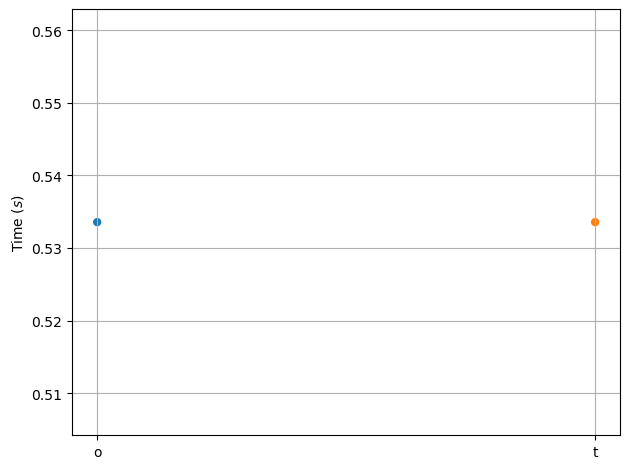

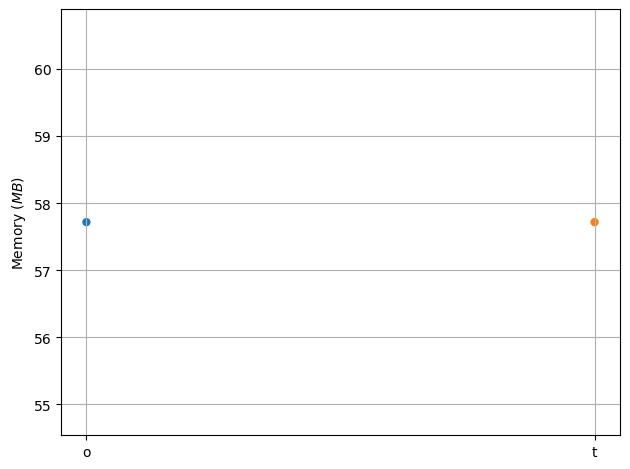

In [48]:
# benchmark plot
test_name_plt = ["o","t"]
# time
fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
            ben[2],
        median(benches[ben[1]].times) * 1e-9,
        color = Utils.colours[ben[1]],
#         alpha = 0.3,
        edgecolors = "none",
    )
end


# ax.legend()
ax.set_ylabel("Time (\$s\$)")
ax.grid(true)
fig.tight_layout()
plt.savefig(plotsdir(
    string("bench_imp", batch_),
    string("bench_imp_time.png"),
))
# close("all")




# memory

fig, ax = plt.subplots()
for ben in enumerate(test_name_plt)
    ax.scatter(
        ben[2],
        benches[ben[1]].memory * 1e-6,
        color = Utils.colours[ben[1]],
#         alpha = 0.3,
        edgecolors = "none",
    )
end


# ax.legend()
ax.set_ylabel("Memory (\$MB\$)")
ax.grid(true)
fig.tight_layout()
# plt.savefig(plotsdir(
#     string("bench_imp", batch_),
#     string("bench_imp_mem.png"),
# ))
# close("all")


# alloc

# fig, ax = plt.subplots()
# for ben in enumerate(test_name_plt)
#     ax.scatter(
#         ben[2],
#         benches[ben[1]].allocs * 1e-6,
#         color = Utils.colours[ben[1]],
# #         alpha = 0.3,
#         edgecolors = "none",
#     )
# end


# # ax.legend()
# ax.set_ylabel("Allocations")
# ax.grid(true)
# fig.tight_layout()
# plt.savefig(plotsdir(
#     string("bench_imp", batch_),
#     string("bench_imp_alloc.png"),
# ))
# # close("all")

In [6]:

file = ["kan_sq_cont_l.png"]
        p = LaminartInitFunc.parameterInit_conv_gpu(
            datadir("img",file[1]),
            Parameters.parameters_f32,
        )
tspan = (0.0f0,10f0)
        u0 = cu(reshape(
            zeros(Float32, p.dim_i, p.dim_j * (5 * p.K + 2)),
            p.dim_i,
            p.dim_j,
            5 * p.K + 2,
            1,
        ))

        arr1 = similar(u0[:, :, 1:2, :])
        arr2 = similar(u0[:, :, 1:1, :])

        f = LaminartFunc.LamFunction(
            arr1, #x
            similar(arr1), #m
            similar(arr1), #s
            arr2, #x_lgn,
            similar(arr1), #C,
            similar(arr1), #H_z,
            similar(arr1), # dy_temp,
            similar(arr1), # dm_temp,
            similar(arr1), # dz_temp,
            similar(arr1), # ds_temp,
            similar(arr2), # dv_temp,
            similar(arr1), # H_z_temp,
            similar(arr2), #  V_temp_1,
            similar(arr2), #  V_temp_2,
            similar(arr1), #  A_temp,
            similar(arr1), #   B_temp
        )

        prob = ODEProblem(f, u0, tspan, p)
#         push!(benchm_gpu, @benchmark solve(prob))
        sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 37-element Array{Float32,1}:
  0.0
  1.0f-6
  9.142678f-6
  5.8165686f-5
  0.00028488153
  0.0011421234
  0.003917934
  0.011830136
  0.032601908
  0.08393783
  0.1872685
  0.34435055
  0.5533185
  ⋮
  6.414108
  6.675271
  6.9125047
  7.2330112
  7.572543
  7.882057
  8.218843
  8.562391
  8.969965
  9.44966
  9.894743
 10.0
u: 37-element Array{CuArray{Float32,4},1}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 

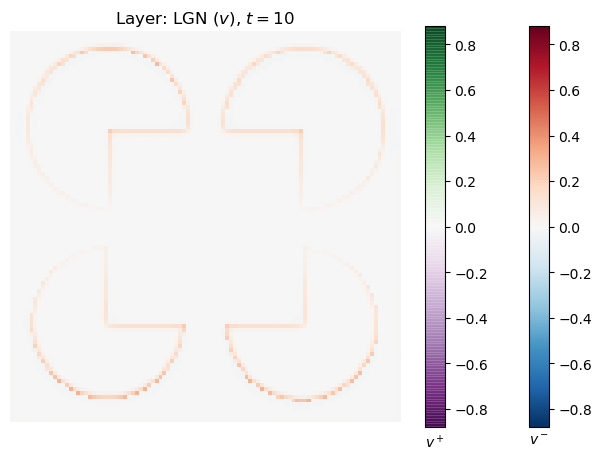

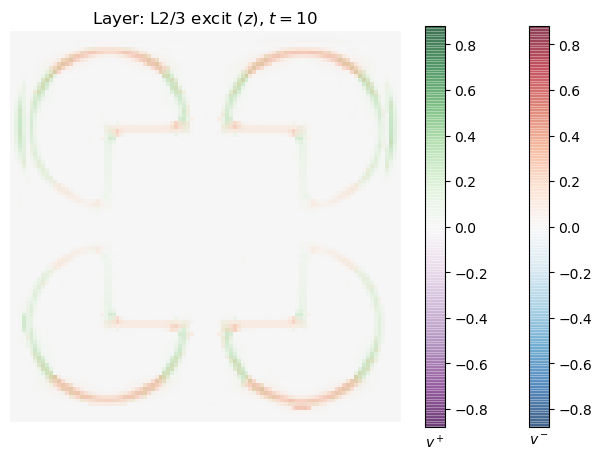

In [20]:
v0 = @view sol(t)[:,:,:,1]
					axMax = findmax(v0)[1]
					k=7
t=10
					fig, ax = plt.subplots()
					v1 = @view sol(t)[:,:,k,1]
					v2 = @view sol(t)[:,:,k+1,1]
					im = ax.imshow(v1, cmap=matplotlib.cm.PRGn,
								   vmax=axMax, vmin=-axMax)
					im2 = ax.imshow(v2, cmap=matplotlib.cm.RdBu_r,
								   vmax=axMax, vmin=-axMax, alpha=0.5)

					cbar = fig.colorbar(im2,  shrink=0.9, ax=ax)
					cbar.ax.set_xlabel("\$v^-\$")
							cbar = fig.colorbar(im,  shrink=0.9, ax=ax)
cbar.set_alpha(0.5)
cbar.draw_all()
					cbar.ax.set_xlabel("\$v^+\$")

					layer=Utils.layers[k]
						plt.title("Layer: $layer, \$t=$t\$")
						plt.axis("off")
						fig.tight_layout()

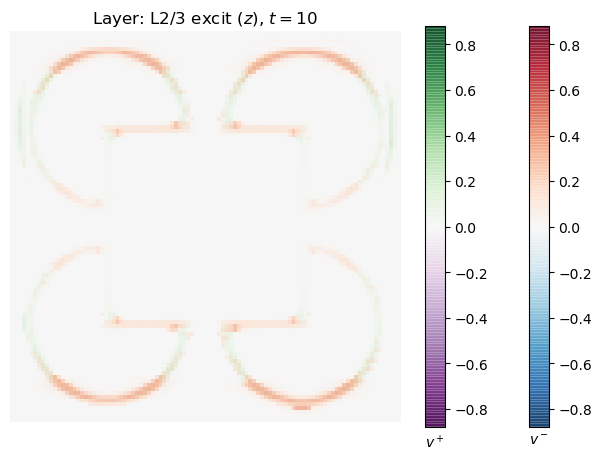

In [16]:
v0 = @view sol(t)[:,:,:,1]
					axMax = findmax(v0)[1]
					k=7
t=10
					fig, ax = plt.subplots()
					v1 = @view sol(t)[:,:,k,1]
					v2 = @view sol(t)[:,:,k+1,1]
					im = ax.imshow(v1, cmap=matplotlib.cm.PRGn,
								   vmax=axMax, vmin=-axMax, alpha=0.7)
					im2 = ax.imshow(v2, cmap=matplotlib.cm.RdBu_r,
								   vmax=axMax, vmin=-axMax, alpha=0.7)

					cbar = fig.colorbar(im2,  shrink=0.9, ax=ax)
					cbar.ax.set_xlabel("\$v^-\$")
							cbar = fig.colorbar(im,  shrink=0.9, ax=ax)
					cbar.ax.set_xlabel("\$v^+\$")

					layer=Utils.layers[k]
						plt.title("Layer: $layer, \$t=$t\$")
						plt.axis("off")
						fig.tight_layout()

In [21]:
readdir(datadir("img"))

25-element Array{String,1}:
 ".ipynb_checkpoints"
 "Iine_gap_1_100_gs.png"
 "Iine_gap_2_100_gs.png"
 "Iine_gap_3_100_gs.png"
 "Iine_gap_4_100_gs.png"
 "Iines_gaps_100_gs.png"
 "diag_dots_100_gs.png"
 "diag_gap_100_gs.png"
 "kan_sq_cont.png"
 "kan_sq_cont_l.png"
 "mo05709.png"
 "stairs_100gs.png"
 "stairs_200gs.png"
 "viper00187.png"
 "viper00661.jpg"
 "viper00715.png"
 "viper00717.png"
 "viper00720.png"
 "viper00721.png"
 "viper00842.jpg"
 "viper00891.jpg"
 "viper00904.jpg"
 "viper00921.jpg"
 "viper01006.jpg"
 "viper01333.jpg"

In [22]:
sol = nothing
u0=nothing
arr1 = nothing
f=nothing
arr2=nothing

In [23]:
run(nvidia-smi)

UndefVarError: UndefVarError: nvidia not defined